In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [2]:
pip install pandas opencv-python pytesseract pillow scikit-image


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached pytesseract-0.3.13-py3-none-any.whl.metadata (11 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Using cached pytesseract-0.3.13-py3-none-any.whl (14 kB)

   -------------------- ------------------- 1/2 [opencv-python]
   -------------------- ------------------- 1/2 [opencv-python]
   -------------------- ------------------- 1/2 [opencv-python]
   -------------------- ------------------- 1/2 [opencv-python]
   ---------------------------------------- 2/2 [opencv-python]



In [ ]:
import numpy as np
import cv2
#from . import multiarray
print(np.__version__)
print(cv2.__version__)

In [ ]:
import cv2
import pytesseract
from pytesseract import Output
import numpy as np
import os
from PIL import Image
from skimage.metrics import structural_similarity as ssim
import pandas as pd
from skimage.measure import label, regionprops

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

<div class="span5 alert alert-info">
<h3>BLOCK 1</h3><br>

Extract valuable features from file of images and load them into dataset

</div>

In [34]:
df = pd.read_excel(r"C:\Users\eshab\Downloads\Capstone3\ig_infographic_stats.xlsx")

df.head()

,image_id,like_count,comment_count
0,1,1865,24
1,2,1502,52
2,3,16800,73
3,4,687,14
4,5,241,4


In [35]:
# Folder where images are stored
image_folder = r"C:\Users\eshab\OneDrive\Pictures\Screenshots"

df.head()

,image_id,like_count,comment_count
0,1,1865,24
1,2,1502,52
2,3,16800,73
3,4,687,14
4,5,241,4


In [36]:
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# Load all image files in order
image_files = sorted([
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])

# Sanity check
if len(image_files) != len(df):
    print(f"{len(image_files)} images vs {len(df)} Excel rows – double check alignment!")

def get_blank_percentage(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY_INV,
        15, 10
    )
    non_zero = cv2.countNonZero(thresh)
    total_pixels = thresh.shape[0] * thresh.shape[1]
    return 100 * (1 - (non_zero / total_pixels))

#refining the handwritten detection, face_count detection, and adding a feature extraction that detects a small white
## square in the upper right corner, which on Instagram show if the post is multiple slides
def get_text_percentage(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    d = pytesseract.image_to_data(gray, output_type=Output.DICT)
    text_area = 0
    for i in range(len(d['text'])):
        try:
            conf = float(d['conf'][i])
        except ValueError:
            continue
        if conf > 30:  # Filter low-confidence detections
            (w, h) = (d['width'][i], d['height'][i])
            text_area += w * h
    total_area = image.shape[0] * image.shape[1]
    return 100 * (text_area / total_area)

def detect_handwriting(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    text = pytesseract.image_to_string(gray, config='--psm 6')
    handwritten_cues = ['sketch', 'ink', 'uneven', 'comic', 'doodle']
    return int(any(cue in text.lower() for cue in handwritten_cues))

def count_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)
    return len(faces)

def detect_carousel(image):
    # Crop top-right corner
    h, w = image.shape[:2]
    corner = image[0:int(h * 0.15), int(w * 0.85):w]
    corner_gray = cv2.cvtColor(corner, cv2.COLOR_BGR2GRAY)
    corner_resized = cv2.resize(corner_gray, (50, 50))

    # Define a white square template
    square = 255 * np.ones((50, 50), dtype=np.uint8)
    similarity, _ = ssim(corner_resized, square, full=True)
    return int(similarity > 0.8)

print('Done!')

Done!


In [39]:
# Feature extraction loop
image_ids, blank_percents, text_percents = [], [], []
handwritten_flags, face_counts, carousel_flags = [], [], []

for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(image_folder, filename)
        image = cv2.imread(image_path)

        if image is None:
            continue

        image_id = os.path.splitext(filename)[0]
        image_ids.append(image_id)
        blank_percents.append(get_blank_percentage(image))
        text_percents.append(get_text_percentage(image))
        handwritten_flags.append(detect_handwriting(image))
        face_counts.append(count_faces(image))
        carousel_flags.append(detect_carousel(image))

df_features = pd.DataFrame({
    'image_id': image_ids,
    'blank_percent': blank_percents,
    'text_percent': text_percents,
    'handwritten': handwritten_flags,
    'face_count': face_counts,
    'carousel': carousel_flags
})

print('Done!')

Done!


In [50]:
# Define a new file path for the merged dataset
new_file_path = r"C:\Users\eshab\Downloads\Capstone3\ig_infographic_stats_merged.xlsx"

# Save the merged DataFrame to the new Excel file
df_merged.to_excel(new_file_path, index=False)

print("Merged file saved successfully!")

Merged file saved successfully!


In [52]:
df = pd.read_excel(r"C:\Users\eshab\Downloads\Capstone3\ig_infographic_stats_merged.xlsx")
df.head()

,image_id,like_count,comment_count,blank_percent,text_percent,handwritten,face_count,carousel
0,1,1865,24,84.507535,25.661791,0,0,0
1,2,1502,52,92.613889,20.563542,0,0,0
2,3,16800,73,94.518954,20.761592,0,0,1
3,4,687,14,79.299427,26.529612,0,0,0
4,5,241,4,79.816514,11.782967,0,0,0


<div class="span5 alert alert-info">
<h3>BLOCK 2</h3><br>

Perform EDA

</div>

In [55]:
# Ensure ratios are handled safely
df['text_blank_ratio'] = df['text_percent'] / (df['blank_percent'] + 1e-5)
df['like_comment_ratio'] = df['like_count'] / (df['comment_count'] + 1e-5)

print('Done!')

Done!


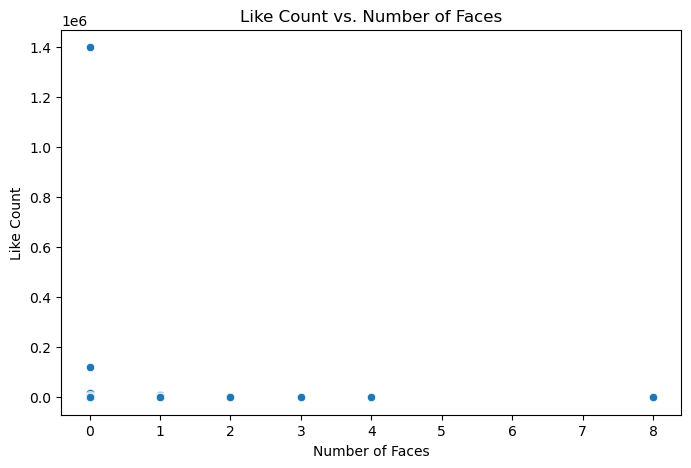

In [58]:
# 1. Scatter plot: like count vs face count
plt.figure(figsize=(8, 5))
sns.scatterplot(x='face_count', y='like_count', data=df)
plt.title('Like Count vs. Number of Faces')
plt.xlabel('Number of Faces')
plt.ylabel('Like Count')
plt.show()

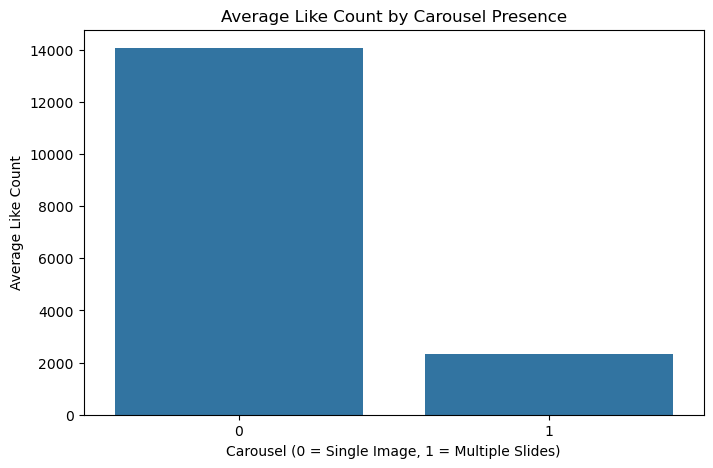

In [59]:
# 2. Bar plot: like count vs carousel
plt.figure(figsize=(8, 5))
sns.barplot(x='carousel', y='like_count', data=df, estimator='mean', errorbar=None)
plt.title('Average Like Count by Carousel Presence')
plt.xlabel('Carousel (0 = Single Image, 1 = Multiple Slides)')
plt.ylabel('Average Like Count')
plt.show()

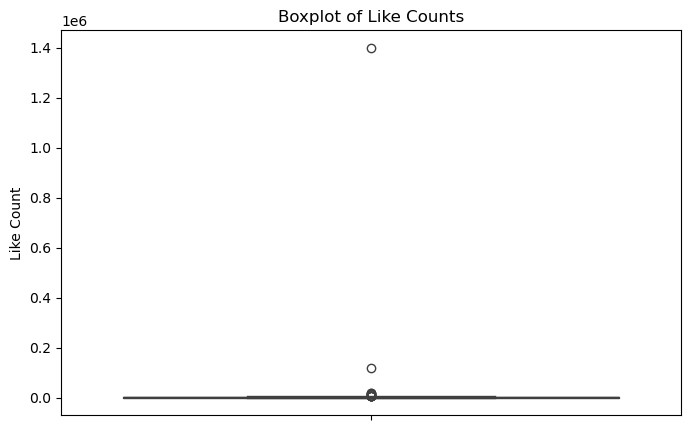

In [60]:
# 3. Boxplot for detecting like count outliers
plt.figure(figsize=(8, 5))
sns.boxplot(y='like_count', data=df)
plt.title('Boxplot of Like Counts')
plt.ylabel('Like Count')
plt.show()

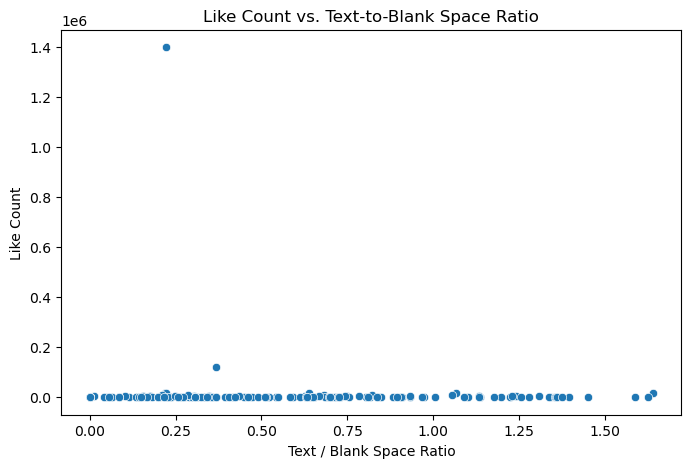

In [61]:
# 4. Scatter plot: text to blank space ratio vs like count
plt.figure(figsize=(8, 5))
sns.scatterplot(x='text_blank_ratio', y='like_count', data=df)
plt.title('Like Count vs. Text-to-Blank Space Ratio')
plt.xlabel('Text / Blank Space Ratio')
plt.ylabel('Like Count')
plt.show()

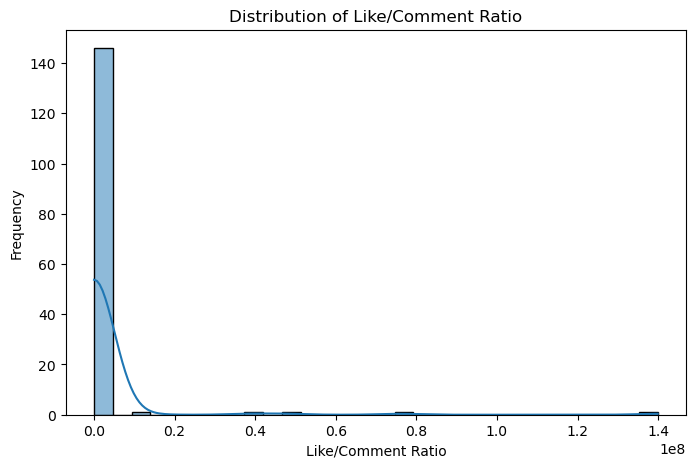

In [62]:
# 5. Histogram of like/comment ratio
plt.figure(figsize=(8, 5))
sns.histplot(df['like_comment_ratio'], bins=30, kde=True)
plt.title('Distribution of Like/Comment Ratio')
plt.xlabel('Like/Comment Ratio')
plt.ylabel('Frequency')
plt.show()